In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz 
!tar xvf spark-3.3.2-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.3.2

--2023-03-11 14:25:29--  https://dlcdn.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz.1’

spark-3.3.2-bin-had 100%[===================>] 285.49M   112MB/s    in 2.5s    

2023-03-11 14:25:32 (112 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz.1’ saved [299360284/299360284]

spark-3.3.2-bin-hadoop3/
spark-3.3.2-bin-hadoop3/LICENSE
spark-3.3.2-bin-hadoop3/NOTICE
spark-3.3.2-bin-hadoop3/R/
spark-3.3.2-bin-hadoop3/R/lib/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.2-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.2-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.2-bin-hadoop3"

In [ ]:
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local[1]").appName("SparkByExamples.com").getOrCreate() 
data = [1,2,3,4,5,6,7,8,9,10,11,12]
rdd_sample = spark.sparkContext.parallelize(data, 2)
rdd_sample.take(5)

[1, 2, 3, 4, 5]

## Data Cleanup

In [ ]:
df = spark.read.format('csv').option('header', 'true').option('inferSchema', 'true').load('/content/drive/MyDrive/Drexel/Winter2023/DSCI632/final/healthcare-dataset-stroke-data.csv')

In [ ]:
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [ ]:
df.count()

5110

In [ ]:
print("Unique Gender Values: ", df.select('gender').distinct().collect())
print("Unique Hypertension Values: ", df.select('hypertension').distinct().collect())
print("Unique Heart Disease Values: ", df.select('heart_disease').distinct().collect())
print("Unique Married Values: ", df.select('ever_married').distinct().collect())
print("Unique Work Type Values: ", df.select('work_type').distinct().collect())
print("Unique Residence Type Values: ", df.select('residence_type').distinct().collect())
print("Unique Glucose Level Values: ", df.select('avg_glucose_level').distinct().collect())
print("Unique BMI Values: ", df.select('bmi').distinct().collect())
print("Unique Smoking Status Values: ", df.select('smoking_status').distinct().collect())

Unique Gender Values:  [Row(gender='Female'), Row(gender='Other'), Row(gender='Male')]
Unique Hypertension Values:  [Row(hypertension=1), Row(hypertension=0)]
Unique Heart Disease Values:  [Row(heart_disease=1), Row(heart_disease=0)]
Unique Married Values:  [Row(ever_married='No'), Row(ever_married='Yes')]
Unique Work Type Values:  [Row(work_type='Never_worked'), Row(work_type='Self-employed'), Row(work_type='Private'), Row(work_type='children'), Row(work_type='Govt_job')]
Unique Residence Type Values:  [Row(residence_type='Urban'), Row(residence_type='Rural')]
Unique Glucose Level Values:  [Row(avg_glucose_level=242.52), Row(avg_glucose_level=60.98), Row(avg_glucose_level=76.46), Row(avg_glucose_level=98.09), Row(avg_glucose_level=73.73), Row(avg_glucose_level=78.75), Row(avg_glucose_level=75.29), Row(avg_glucose_level=79.89), Row(avg_glucose_level=77.19), Row(avg_glucose_level=206.4), Row(avg_glucose_level=61.78), Row(avg_glucose_level=151.25), Row(avg_glucose_level=95.57), Row(avg_g

From the above code, we can see that the BMI column contains N/A's.  We will remove these values.

In [ ]:
df = df.filter(df.bmi != 'N/A')

In [ ]:
# removing rows that contain N/A so we now have 4909 rows of data
df.count()

4909

# Exploratory Data Analysis

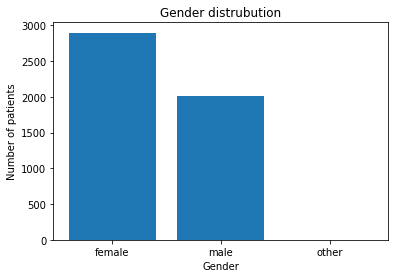

In [ ]:
from pyspark.sql.functions import count
import matplotlib.pyplot as plt

female = df.filter(df.gender == 'Female').count()
male = df.filter(df.gender == 'Male').count()
other = df.filter(df.gender == 'Other').count()

plt.bar(["female", "male", "other"], [female, male, other])
plt.xlabel("Gender")
plt.ylabel("Number of patients")
plt.title("Gender distrubution")
plt.show()

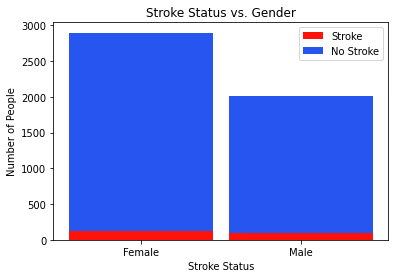

In [ ]:
from pyspark.sql.functions import count

# count of females and males that had and didn't have strokes
female = df.filter(df.gender == 'Female')
fstrokeY = female.filter(female.stroke == 1)
fstrokeN = female.filter(female.stroke == 0)

male = df.filter(df.gender == 'Male')
mstrokeY = male.filter(male.stroke == 1)
mstrokeN = male.filter(male.stroke == 0)

# chart
status = ['Female', 'Male']
stro = [fstrokeY.count(), mstrokeY.count()]
nostro = [fstrokeN.count(), mstrokeN.count()]

plt.bar(status, stro,  0.9, color = '#ff120a', label='Stroke')
plt.bar(status, nostro, 0.9, bottom = stro, color = '#2655f0', label='No Stroke')

plt.xlabel("Stroke Status")
plt.ylabel("Number of People")
plt.title('Stroke Status vs. Gender')
plt.legend()
plt.show()

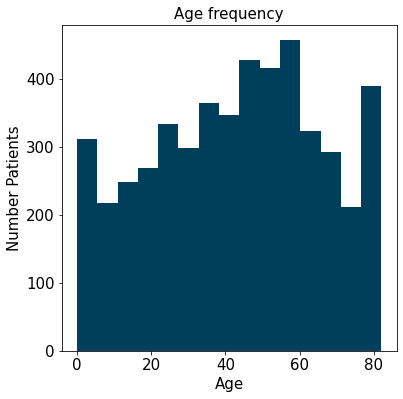

In [ ]:
# age distribution
hist_fig = plt.figure(figsize = (6, 6))

x = df.select("age").rdd.flatMap(lambda x: x).collect()

_  = plt.hist(x, bins = 15, color='#003f5c')

plt.tick_params(labelsize = 15)
_ = plt.title("Age frequency", fontsize = 15)
_ = plt.ylabel("Number Patients", fontsize = 15)
_ = plt.xlabel("Age", fontsize = 15)

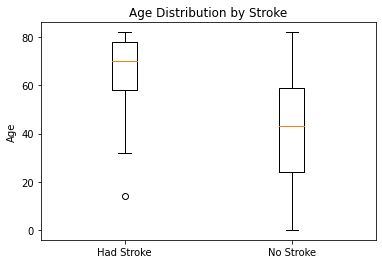

In [ ]:
# stroke vs. no stroke compared to age
had_stroke = df.filter(df.stroke == 1).select('age').rdd.flatMap(lambda x: x).collect()
no_stroke = df.filter(df.stroke == 0).select('age').rdd.flatMap(lambda x: x).collect()

data = [had_stroke ,no_stroke]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Had Stroke', 'No Stroke'])
ax.set_ylabel('Age')
ax.set_title('Age Distribution by Stroke')
plt.show()

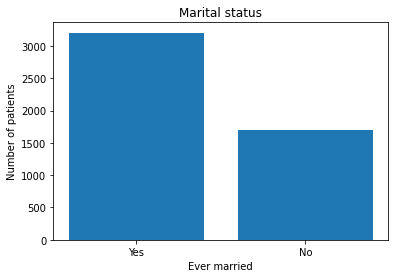

In [ ]:
yes = df.filter(df.ever_married == 'Yes').count()
no = df.filter(df.ever_married == 'No').count()

plt.bar(["Yes", "No"], [yes, no])
plt.xlabel("Ever married")
plt.ylabel("Number of patients")
plt.title("Marital status")
plt.show()

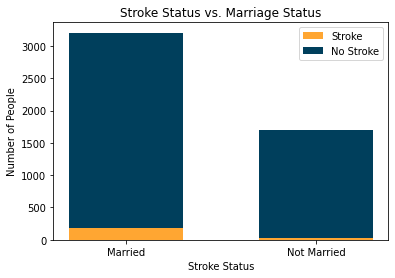

In [ ]:
# marriage vs. stroke

married = df.filter(df.ever_married == 'Yes')
mstrokeY = married.filter(married.stroke == 1)
mstrokeN = married.filter(married.stroke == 0)

nmarried = df.filter(df.ever_married == 'No')
nmstrokeY = nmarried.filter(nmarried.stroke == 1)
nmstrokeN = nmarried.filter(nmarried.stroke == 0)

# chart
status = ['Married', 'Not Married']
s = [mstrokeY.count(), nmstrokeY.count()]
ns = [mstrokeN.count(), nmstrokeN.count()]

w = 0.6
plt.bar(status, s, w, color = '#ffa632', label='Stroke')
plt.bar(status, ns, w, bottom = s, color = '#003f5c', label='No Stroke')

plt.xlabel("Stroke Status")
plt.ylabel("Number of People")
plt.title('Stroke Status vs. Marriage Status')
plt.legend()
plt.show()

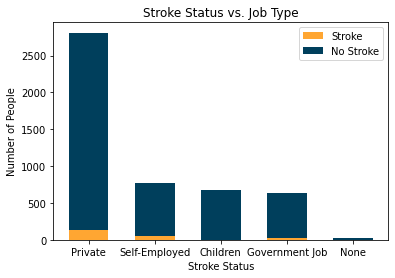

In [ ]:
# job type vs. stroke
private = df.filter(df.work_type =='Private')
pristrokeY = private.filter(private.stroke==1)
pristrokeN = private.filter(private.stroke==0)

# self-employed
sel = df.filter(df.work_type ==  'Self-employed')
selstrokeY = sel.filter(sel.stroke==1)
selstrokeN = sel.filter(sel.stroke==0)

 # children
child = df.filter(df.work_type == 'children')
chstrokeY = child.filter(child.stroke==1)
chstrokeN = child.filter(child.stroke==0)

# government job
gov = df.filter(df.work_type == 'Govt_job')
govstrokeY = gov.filter(gov.stroke==1)
govstrokeN = gov.filter(gov.stroke==0)

# never worked
never =df.filter(df.work_type =='Never_worked' )
nevstrokeY = never.filter(never.stroke==1)
nevstrokeN = never.filter(never.stroke==0)

# chart
status = ['Private', 'Self-Employed', 'Children', 'Government Job', 'None']
st = [pristrokeY.count(),selstrokeY.count(),chstrokeY.count(),govstrokeY.count(),nevstrokeY.count()]
nost = [pristrokeN.count(),selstrokeN.count(),chstrokeN.count(),govstrokeN.count(),nevstrokeN.count()]

w = 0.6
plt.bar(status, st, w, color = '#ffa632', label='Stroke')
plt.bar(status, nost, w, bottom = st, color = '#003f5c', label='No Stroke')

plt.xlabel("Stroke Status")
plt.ylabel("Number of People")
plt.title('Stroke Status vs. Job Type')
plt.legend()
plt.show()

In [ ]:
df.groupBy('Residence_type').agg(count('*').alias('count')).show()

+--------------+-----+
|Residence_type|count|
+--------------+-----+
|         Urban| 2490|
|         Rural| 2419|
+--------------+-----+



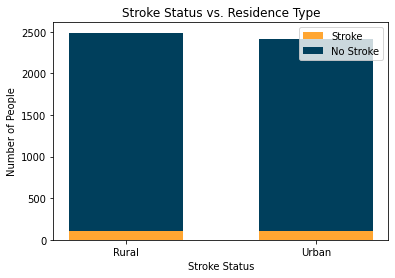

In [ ]:
# residence type vs. stroke
urban = df.filter(df.Residence_type== 'Urban')
ustrokeY = urban.filter(urban.stroke== 1 )
ustrokeN = urban.filter(urban.stroke== 0 )

rural = df.filter(df.Residence_type== 'Rural')
rstrokeY = rural.filter(rural.stroke== 1 )
rstrokeN = rural.filter(rural.stroke== 0)

# chart
status = ['Rural', 'Urban']
strok = [ustrokeY.count(), rstrokeY.count()]
nostrok = [ustrokeN.count(), rstrokeN.count()]

w = 0.6

plt.bar(status, strok, w, color = '#ffa632', label='Stroke')
plt.bar(status, nostrok, w, bottom = strok, color = '#003f5c', label='No Stroke')

plt.xlabel("Stroke Status")
plt.ylabel("Number of People")
plt.title('Stroke Status vs. Residence Type')
plt.legend()
plt.show()

In [ ]:
df.groupBy('hypertension').agg(count('*').alias('count')).show()

+------------+-----+
|hypertension|count|
+------------+-----+
|           1|  451|
|           0| 4458|
+------------+-----+



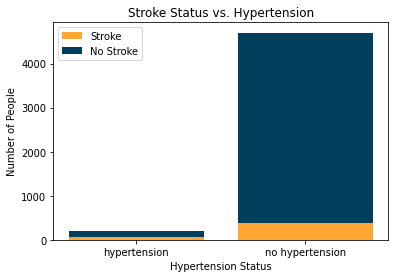

60 391
149 4309


In [ ]:
# hypertension vs. stroke
hyper = df.filter(df.hypertension == 1)
hyper_stroke = hyper.filter(hyper.stroke== 1)
hyper_noStroke = hyper.filter(hyper.stroke== 0)

hs_num = hyper_stroke.count()
hns_num = hyper_noStroke.count()

not_hyper = df.filter(df.hypertension == 0)
nh_stroke = not_hyper.filter(not_hyper.stroke== 1)
nh_nstroke = not_hyper.filter(not_hyper.stroke== 0)
nhs_num = nh_stroke.count()
nhns_num = nh_nstroke.count()


# chart
x = ['hypertension', 'no hypertension']
hyper = [hs_num, hns_num]
no_hyper = [nhs_num, nhns_num] 

plt.bar(x, hyper, color='#ffa632', label='Stroke')
plt.bar(x, no_hyper, bottom=hyper, color='#003f5c', label='No Stroke')
plt.xlabel("Hypertension Status")
plt.ylabel("Number of People")
plt.legend()
plt.title('Stroke Status vs. Hypertension')
plt.show()

print(hs_num, hns_num)    # 13% of people with hypertension also had a stroke
print(nhs_num, nhns_num)  # 3 % of people without hypertension had a stroke

In [ ]:
df.groupBy('heart_disease').agg(count('*').alias('count')).show()

+-------------+-----+
|heart_disease|count|
+-------------+-----+
|            1|  243|
|            0| 4666|
+-------------+-----+



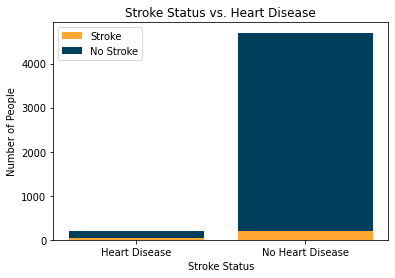

In [ ]:
# hypertension vs. stroke
heart = df.filter(df.heart_disease == 1)
heart_stroke = heart.filter(heart.stroke== 1)
heart_noStroke = heart.filter(heart.stroke== 0)

hs_num = heart_stroke.count()
hns_num = heart_noStroke.count()

noheart = df.filter(df.heart_disease == 0)
nheart_stroke = noheart.filter(noheart .stroke== 1)
nheart_nstroke = noheart.filter(noheart .stroke== 0)
nhs_num = nheart_stroke.count()
nhns_num = nheart_nstroke.count()

# chart
x = ['Heart Disease', 'No Heart Disease']
hyper = [hs_num, hns_num]
no_hyper = [nhs_num, nhns_num] 

plt.bar(x, hyper, color='#ffa632', label='Stroke')
plt.bar(x, no_hyper, bottom=hyper, color='#003f5c', label='No Stroke')
plt.xlabel("Stroke Status")
plt.ylabel("Number of People")
plt.legend()
plt.title('Stroke Status vs. Heart Disease')
plt.show()

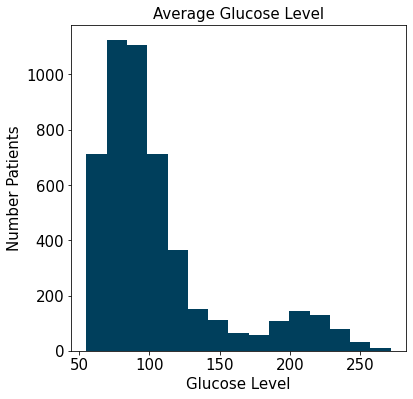

In [ ]:
# avg glucose level
hist_fig = plt.figure(figsize = (6, 6))

x = df.select("avg_glucose_level").rdd.flatMap(lambda x: x).collect()

_  = plt.hist(x, bins = 15, color='#003f5c')

plt.tick_params(labelsize = 15)
_ = plt.title("Average Glucose Level", fontsize = 15)
_ = plt.ylabel("Number Patients", fontsize = 15)
_ = plt.xlabel("Glucose Level", fontsize = 15)

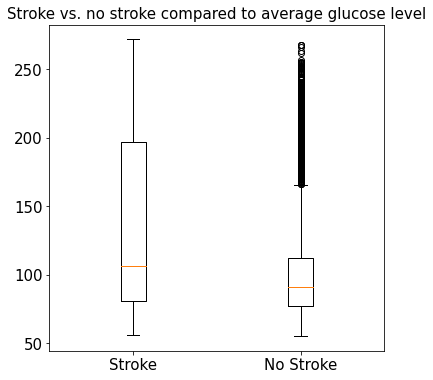

In [ ]:
# glucose level vs. stroke
had_stroke = df.filter(df.stroke== 1).select('avg_glucose_level').rdd.flatMap(lambda x: x).collect()
no_stroke = df.filter(df.stroke== 0).select('avg_glucose_level').rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize = (6,6))
_ = plt.boxplot(
    [had_stroke, 
     no_stroke], 
    labels = ["Stroke", "No Stroke"])
plt.tick_params(labelsize = 15)
_ = plt.title("Stroke vs. no stroke compared to average glucose level", fontsize = 15)

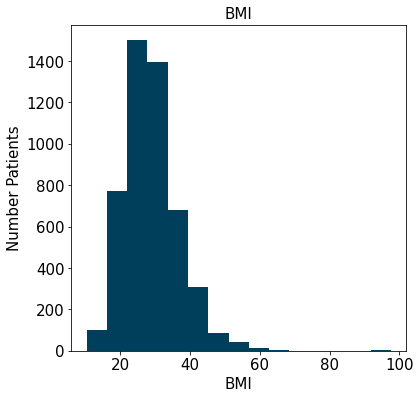

In [ ]:
# BMI
from pyspark.sql.functions import col

hist_fig = plt.figure(figsize = (6, 6))

x = df.select(col("bmi").cast("float")).rdd.flatMap(lambda x: x).collect()

_  = plt.hist(x, bins = 15, color='#003f5c')

plt.tick_params(labelsize = 15)
_ = plt.title("BMI", fontsize = 15)
_ = plt.ylabel("Number Patients", fontsize = 15)
_ = plt.xlabel("BMI", fontsize = 15)

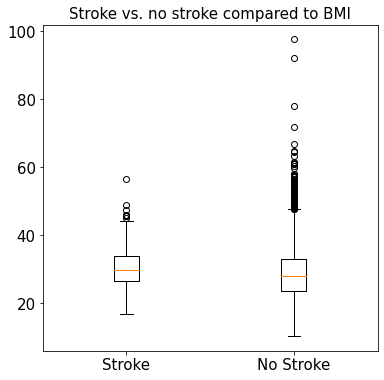

In [ ]:
# BMI vs. stroke
had_stroke = df.filter(df.stroke == 1).select(col("bmi").cast("float")).rdd.flatMap(lambda x: x).collect()
no_stroke = df.filter(df.stroke == 0).select(col("bmi").cast("float")).rdd.flatMap(lambda x: x).collect()

fig = plt.figure(figsize = (6,6))
_ = plt.boxplot(
    [had_stroke, 
     no_stroke
     ], 
    labels = ["Stroke", "No Stroke"])
plt.tick_params(labelsize = 15)
_ = plt.title("Stroke vs. no stroke compared to BMI", fontsize = 15)

In [ ]:
df.groupBy('smoking_status').agg(count('*').alias('count')).show()

+---------------+-----+
| smoking_status|count|
+---------------+-----+
|         smokes|  737|
|        Unknown| 1483|
|   never smoked| 1852|
|formerly smoked|  837|
+---------------+-----+



Had Stroke--  Never Smoked:  84 , Unknown:  29 , Formerly Smoked:  57 , Smokes:  39
No Stroke--  Never Smoked:  1768 , Unknown:  1454 , Formerly Smoked:  780 , Smokes:  698


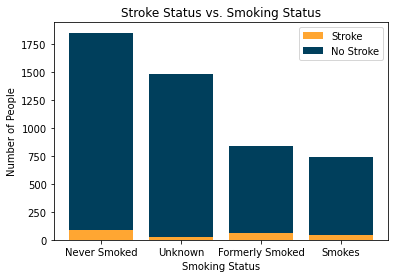

In [ ]:
#smoking status vs stroke
had_stroke = df.filter(df.stroke == 1)
no_stroke = df.filter(df.stroke == 0)

hadS_never = had_stroke.filter(col('smoking_status') == 'never smoked').count()
hadS_unknown = had_stroke.filter(col('smoking_status') == 'Unknown').count()
hadS_formerly = had_stroke.filter(col('smoking_status') == 'formerly smoked').count()
hadS_smokes = had_stroke.filter(col('smoking_status') == 'smokes').count()
print('Had Stroke-- ', 'Never Smoked: ', hadS_never,',', 'Unknown: ', hadS_unknown,',', 'Formerly Smoked: ',hadS_formerly,',', 'Smokes: ',hadS_smokes)

noS_never = no_stroke.filter(col('smoking_status') == 'never smoked').count()
noS_unknown = no_stroke.filter(col('smoking_status') == 'Unknown').count()
noS_formerly = no_stroke.filter(col('smoking_status') == 'formerly smoked').count()
noS_smokes = no_stroke.filter(col('smoking_status') == 'smokes').count()
print('No Stroke-- ', 'Never Smoked: ', noS_never,',', 'Unknown: ', noS_unknown,',', 'Formerly Smoked: ',noS_formerly,',', 'Smokes: ', noS_smokes)

# chart
x = ['Never Smoked', 'Unknown', 'Formerly Smoked', 'Smokes']
hadS = [hadS_never, hadS_unknown, hadS_formerly, hadS_smokes]
noS = [noS_never, noS_unknown, noS_formerly, noS_smokes] 

plt.bar(x, hadS, color='#ffa632', label='Stroke')
plt.bar(x, noS, bottom=hadS, color='#003f5c', label='No Stroke')
plt.xlabel("Smoking Status")
plt.ylabel("Number of People")
plt.legend()
plt.title('Stroke Status vs. Smoking Status')
plt.show()

In [ ]:
df.describe().show()

+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|                id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|              4909|  4909|              4909|               4909|               4909|        4909|     4909|          4909|              4909|              4909|          4909|               4909|
|   mean|37064.313505805665|  null|42.865373803218596|0.09187207170503157|0.04950091668364229|        null|     null|          null|105.30514972499458|28.893236911794673|      

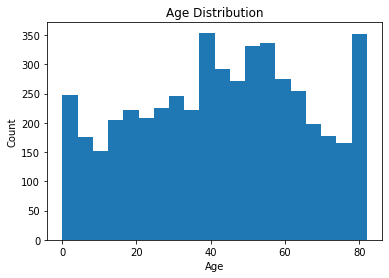

In [ ]:
plt.hist(df.select('age').rdd.flatMap(lambda x: x).collect(), bins=20)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age Distribution")
plt.show()

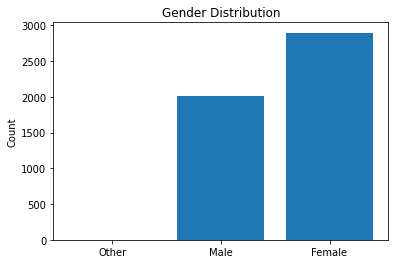

In [ ]:
gender_count = df.groupBy('gender').count().orderBy('count').rdd.map(lambda x: (x[0], int(x[1]))).collect()
gender_labels = [x[0] for x in gender_count]
gender_values = [x[1] for x in gender_count]
plt.bar(gender_labels, gender_values)
#plt.xlabel('Gender')
plt.ylabel('Count')
plt.title("Gender Distribution")
plt.show()

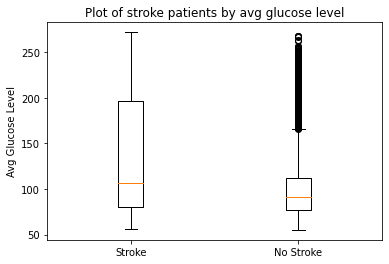

In [ ]:
avg_glucose_data_stroke = df.filter(df.stroke == 1).select('avg_glucose_level').rdd.flatMap(lambda x: x).collect()
avg_glucose_data_no_stroke = df.filter(df.stroke == 0).select('avg_glucose_level').rdd.flatMap(lambda x: x).collect()

data = [avg_glucose_data_stroke ,avg_glucose_data_no_stroke]
fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(['Stroke', 'No Stroke'])
ax.set_ylabel('Avg Glucose Level')
ax.set_title('Plot of stroke patients by avg glucose level')
plt.show()

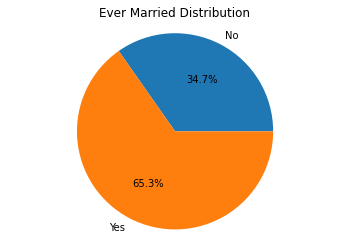

In [ ]:
# Create a pie chart of the 'ever_married' column
ever_married_count = df.groupBy('ever_married').count().orderBy('count').rdd.map(lambda x: (x[0], int(x[1]))).collect()
ever_married_labels = [x[0] for x in ever_married_count]
ever_married_values = [x[1] for x in ever_married_count]
plt.pie(ever_married_values, labels=ever_married_labels, autopct='%1.1f%%')
plt.axis('equal')
plt.ylabel('')
plt.title('Ever Married Distribution')
plt.show()
#plt.title('Marriage Status')

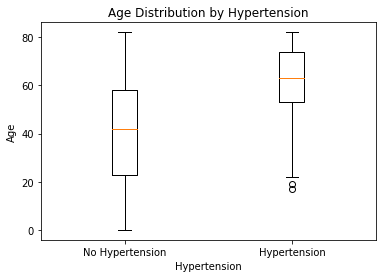

In [ ]:
hypertension_data = df.select('hypertension', 'age')
hypertension_0_data = hypertension_data.filter(hypertension_data.hypertension == 0).rdd.flatMap(lambda x: [x[1]]).collect()
hypertension_1_data = hypertension_data.filter(hypertension_data.hypertension == 1).rdd.flatMap(lambda x: [x[1]]).collect()
plt.boxplot([hypertension_0_data, hypertension_1_data])
plt.xticks([1, 2], ['No Hypertension', 'Hypertension'])
plt.xlabel('Hypertension')
plt.ylabel('Age')
plt.title('Age Distribution by Hypertension')
plt.show()

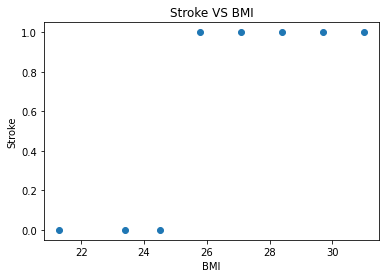

In [ ]:
import matplotlib.pyplot as plt

bmi = [21.3, 23.4, 24.5, 25.8, 27.1, 28.4, 29.7, 31.0]
stroke = [0, 0, 0, 1, 1, 1, 1, 1]

plt.scatter(bmi, stroke)
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Stroke VS BMI')
plt.show()

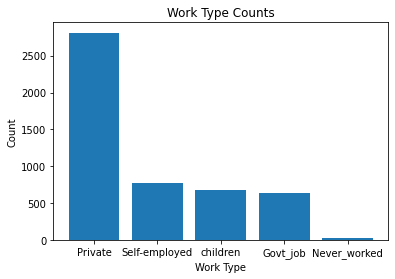

In [ ]:
work_type_counts = df.groupBy('work_type').count().orderBy('count', ascending=False)

# Extract work types and counts as separate lists
work_types = work_type_counts.select('work_type').rdd.flatMap(lambda x: x).collect()
counts = work_type_counts.select('count').rdd.flatMap(lambda x: x).collect()

# Create a bar chart of work type counts
plt.bar(work_types, counts)
plt.title('Work Type Counts')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.show()

# Model: Regression

In [ ]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# categorical cols to numeric
gender_indexer = StringIndexer(inputCol="gender", outputCol="genderIndex")
ever_married_indexer = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
work_type_indexer = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
residence_type_indexer = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
bmi_indexer = StringIndexer(inputCol="bmi", outputCol="bmiIndex")
smoking_status_indexer = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")

# one hot encoding multi-categorical cols
onehotencoder_gender_vector = OneHotEncoder(inputCol="genderIndex", outputCol="gender_vec")
onehotencoder_work_type_vector = OneHotEncoder(inputCol="work_typeIndex", outputCol="work_type_vec")
onehotencoder_resdience_type_vector = OneHotEncoder(inputCol="Residence_typeIndex", outputCol="residence_type_vec")
onehotencoder_smoking_status_vector = OneHotEncoder(inputCol="smoking_statusIndex", outputCol="smoking_status_vec")

stages = [gender_indexer, ever_married_indexer, work_type_indexer, residence_type_indexer, bmi_indexer, smoking_status_indexer,
          onehotencoder_gender_vector, onehotencoder_work_type_vector, onehotencoder_resdience_type_vector, onehotencoder_smoking_status_vector]

df = df.withColumn("stroke", df["stroke"].cast("float"))

cols = ["age", "hypertension", "heart_disease", "avg_glucose_level", "ever_marriedIndex", "bmiIndex", "gender_vec", "work_type_vec", "residence_type_vec", "smoking_status_vec"]
stages.append(VectorAssembler(inputCols=cols, outputCol='features'))
#assembler = VectorAssembler(inputCols=cols, outputCol='features')

In [ ]:
training_df, test_df = df.randomSplit([0.8, 0.2])

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml import classification

stages.append(classification.LogisticRegression(labelCol = 'stroke', featuresCol = 'features'))
model = Pipeline(stages=stages)

# training data
training_model = model.fit(training_df).transform(training_df)
training_model.show(5)

+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+--------+-------------------+-------------+-------------+------------------+------------------+--------------------+--------------------+--------------------+----------+
| id|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi|smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|bmiIndex|smoking_statusIndex|   gender_vec|work_type_vec|residence_type_vec|smoking_status_vec|            features|       rawPrediction|         probability|prediction|
+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+--------------+------+-----------+-----------------+--------------+-------------------+--------+-------------------+-------------+-------------+------------------+--------

In [ ]:
test_model = model.fit(test_df).transform(test_df)
test_model.show(5)

+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+--------+-------------------+-------------+-------------+------------------+------------------+--------------------+--------------------+--------------------+----------+
| id|gender| age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|genderIndex|ever_marriedIndex|work_typeIndex|Residence_typeIndex|bmiIndex|smoking_statusIndex|   gender_vec|work_type_vec|residence_type_vec|smoking_status_vec|            features|       rawPrediction|         probability|prediction|
+---+------+----+------------+-------------+------------+---------+--------------+-----------------+----+---------------+------+-----------+-----------------+--------------+-------------------+--------+-------------------+-------------+-------------+------------------+-----

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
pred_train_rdd = training_model.select("prediction", "stroke").rdd.map(tuple)

metrics_train = MulticlassMetrics(pred_train_rdd)
print("Training Accuracy: ")
metrics_train.accuracy

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Training Accuracy: 


0.9566968781470292

In [ ]:
pred_test_rdd = test_model.select("prediction", "stroke").rdd.map(tuple)

metrics_test = MulticlassMetrics(pred_test_rdd)
print("Test Accuracy: ")
metrics_test.accuracy

Test Accuracy: 


0.96051227321238